In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFE
import matplotlib.pyplot as pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_string_dtype
from datapreparation import *
from sklearn.utils import resample
from sklearn.metrics import classification_report, SCORERS, roc_curve, auc

In [34]:
flights = pd.read_csv('/Users/user/Documents/Github/flightstatus/data/dev/flights_processed.csv')

In [49]:
datatrain = flights[flights.MONTH<=6]
dataval = flights[(flights.MONTH>=7)&(flights.MONTH<=9)]
datatest = flights[flights.MONTH<=10]

In [54]:
best_md =6; best_mcw =6; best_g =0; best_s =0.8; best_cb =0.8; best_l1 = 0; best_l2 =0; best_lr =0.1;
best_estimators = 999;
m_xgb = XGBClassifier(max_depth=best_md,
                      min_child_weight=best_mcw,
                      gamma=best_g,
                      subsample=best_s,
                      colsample_bytree=best_cb,
                      learning_rate = best_lr,
                      reg_alpha = best_l1, reg_lambda = best_l2,
                      scale_pos_weight=35,
                      objective= 'binary:logistic',
                      random_state=123,
                      n_jobs=-1, n_estimators = best_estimators)
eval_set = [(datatrain.drop(['TARGET'], axis=1), datatrain['TARGET']),
           (dataval.drop(['TARGET'], axis=1), dataval['TARGET'])]
m_xgb.fit(datatrain.drop(['TARGET'], axis=1), datatrain['TARGET'], 
          eval_set=eval_set, eval_metric=['logloss'], early_stopping_rounds=15, verbose=True)

[0]	validation_0-logloss:0.718347	validation_1-logloss:0.724912
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-logloss:0.751014	validation_1-logloss:0.760862
[2]	validation_0-logloss:0.785375	validation_1-logloss:0.799037
[3]	validation_0-logloss:0.821795	validation_1-logloss:0.839015
[4]	validation_0-logloss:0.858892	validation_1-logloss:0.880382
[5]	validation_0-logloss:0.897089	validation_1-logloss:0.922237
[6]	validation_0-logloss:0.937083	validation_1-logloss:0.964683
[7]	validation_0-logloss:0.975692	validation_1-logloss:1.00752
[8]	validation_0-logloss:1.01498	validation_1-logloss:1.0496
[9]	validation_0-logloss:1.0542	validation_1-logloss:1.09106
[10]	validation_0-logloss:1.09242	validation_1-logloss:1.13268
[11]	validation_0-logloss:1.13114	validation_1-logloss:1.1745
[12]	validation_0-logloss:1.16971	validation_1-logloss:1.21357
[13]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=None, n_estimators=999, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=35, seed=None,
              silent=None, subsample=0.8, verbosity=1)

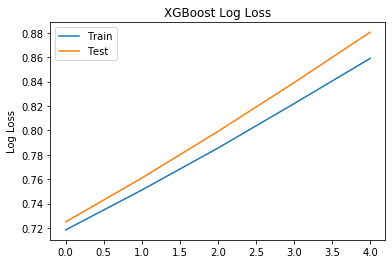

In [53]:
# retrieve performance metrics
results = m_xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

In [56]:
print(classification_report(datatest['TARGET'], m_xgb.predict(datatest.drop(['TARGET'],axis=1))))

              precision    recall  f1-score   support

           0       0.98      0.00      0.01   2867002
           1       0.35      1.00      0.52   1518704

    accuracy                           0.35   4385706
   macro avg       0.67      0.50      0.26   4385706
weighted avg       0.76      0.35      0.18   4385706

